# Dataset Evaulation

This file will ingest a dataset and evaulate this using a modular pipeline

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy
import seaborn as sns
import warnings

## 2. Dataset Ingestion
This section will ingest the dataset from various sources into a common format (pandas dataframe)

In [ ]:
def ingest_csv(path, col):
    """
    Ingests a CSV file into a pandas DataFrame, renames col to 'time',
    converts the 'time' column to datetime objects, and sets it as the index.
    
    Args:
        path (str): The file path to the CSV file.
        col (str): The column name to rename to 'time'.
    
    Returns:
        pd.DataFrame: A DataFrame with 'time' as the index and parsed datetime values.
    """

    df = pd.read_csv(path)
    df.rename(columns={col: 'time'}, inplace=True)    # For the test dataset and change if needed
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    return df


def ingest_json(path):
    pass


def ingest_api(url):
    pass


def cols(df):
    """
    Returns: The column names of the arg dataframe
    """

    return df.columns


def combine_dfs(dfs):
    """
    Combines a list of time series into a single time series on the time column

    Args:
        dfs (list of pd.DataFrame): List of dataframes to combine
    
    Returns:    
        pd.DataFrame: single dataframe with combined data
    """

    

## 3. Dataset Quality

In [3]:
def count_null(df, field):
    """
    Counts the number of null items in the specified fields of the dataframe.

    Args:
        df (pd.DataFrame): The dataframe to check.
        field (list/str/None): List of fields (column names) / single field to / all fields to count nulls for

    Returns:
        dict: A dictionary with field names as keys and null counts as values.
    """

    if field is None:
        return {f: df[f].isnull().sum() for f in df.columns}
    elif isinstance(field, str):
        return {field: df[field].isnull().sum()}
    else:
        return {f: df[f].isnull().sum() for f in field}


def heatmap_null(df):
    """
    Create a heatmap of null values in a DataFrame. TODO

    Args:
        df (pd.DataFrame): The DataFrame to create a heatmap for
    """

    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
    plt.title('Heatmap of Null Values')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()


def outliers_iqr(df, cols):
    """
    Detect outliers in specified columns of a DataFrame using the IQR (Interquartile Range) method.

    Args: 
        df (pd.DataFrame): The DataFrame input
        cols (list of str): List of column names to check for outliers
    
    Returns:
        pd.DataFrame: A DataFrame of booleans for the specified columns where True indicates an outlier.
    """

    # Only keep numeric columns from the provided cols
    cols_to_check = [col for col in cols if pd.api.types.is_numeric_dtype(df[col])]

    outliers = pd.DataFrame(False, index=df.index, columns=cols_to_check)

    for col in cols_to_check:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = (df[col] < lower_bound) | (df[col] > upper_bound)

    return outliers


def outliers_zscore(df, cols):
    """
    Detect outliers in specified columns of a DataFrame using the Z-score method.

    Args:
        df (pd.DataFrame): The DataFrame input
        cols (list of str): List of column names to check for outliers
    
    Returns:
        pd.DataFrame: A DataFrame of booleans for the specified columns where True indicates an outlier.
    """

    # Only keep numeric columns from the provided cols
    cols_to_check = [col for col in cols if pd.api.types.is_numeric_dtype(df[col])]

    outliers = pd.DataFrame(False, index=df.index, columns=cols_to_check)
    
    for col in cols_to_check:
        mean = df[col].mean()
        std = df[col].std()
        
        # Directly compare to mean ± 3*std for outlier detection (equivalent to |z| > 3)
        outliers[col] = ~df[col].between(mean - 3*std, mean + 3*std)

    return outliers


def filter_outliers(df, outliers):
    """
    Given a df and a boolean df outliers remove rows from df where any value is marked as an outlier (True in outliers) and return the filtered DataFrame.

    Args:
        df (pd.DataFrame): The dataframe to filter
        outliers (pd.DataFrame): A boolean dataframe of the same shape as df where True indicates an outlier
    
    Returns:
        pd.DataFrame: The filtered dataframe
    """

    mask = ~outliers.any(axis=1)
    return df[mask]

## 4. Dataset Cleaning

In [4]:
def drop_null_rows(df):
    """
    Delete rows if they have any null values.
    
    Args:
        df (pd.DataFrame): The dataframe to clean
    
    Returns:
        pd.DataFrame: Dataframe with rows containing any null values removed
    """

    return df.dropna()


def drop_null_columns(df, threshold=0.5):
    """
    Delete entire columns if the number of null values exceeds a threshold.
    
    Args:
        df (pd.DataFrame): The dataframe to clean
        threshold (float): Threshold between 0 and 1. Columns with nulls > threshold * total_rows are dropped
    
    Returns:
        pd.DataFrame: Dataframe with columns exceeding null threshold removed
    """

    if not (0 <= threshold <= 1):
        raise ValueError("Threshold must be between 0 and 1")
    
    # Calculate proportion of nulls in each column
    null_proportions = df.isnull().sum() / len(df)
    
    # Drop columns where null proportion exceeds threshold
    columns_to_keep = null_proportions[null_proportions <= threshold].index
    
    return df[columns_to_keep]


def fill_null_method(df, cols, method='mean'):
    """
    Fill null values in specified columns of a DataFrame using various methods.
    
    Args:
        df (pd.DataFrame): The dataframe to clean
        cols (list of str): List of columns to fill nulls for
        method (str): 
            - 'mean': Replace with column mean (numeric only)
            - 'median': Replace with column median (numeric only)
            - 'backfill': Backward fill (propagate last valid observation forward)
            - 'forwardfill': Forward fill (propagate first valid observation backward)
            - 'linear_interpolation': Linear interpolation
            - 'time_interpolation': Time interpolation
            - 'nearest_interpolation': Nearest interpolation
    
    Returns:
        pd.DataFrame: Dataframe with null values filled for specified columns
    """
    df_filled = df.copy()
    
    # Validate columns exist first
    cols_to_fill = [col for col in cols if col in df.columns]
    if not cols_to_fill:
        raise ValueError("No valid columns found in the provided list")
    
    # Handle forward fill
    if method == 'forwardfill':
        for col in cols_to_fill:
            df_filled[col] = df[col].ffill()
        return df_filled

    # Handle backward fill
    elif method == 'backfill':
        for col in cols_to_fill:
            df_filled[col] = df[col].bfill()
        return df_filled

    # Handle linear interpolation
    elif method == 'linear_interpolation':
        for col in cols_to_fill:
            df_filled[col] = df[col].interpolate(method='linear')
        return df_filled
    
    # Handle time interpolation
    elif method == 'time_interpolation':
        for col in cols_to_fill:
            df_filled[col] = df[col].interpolate(method='time')
        return df_filled

    # Handle nearest interpolation
    elif method == 'nearest_interpolation':
        for col in cols_to_fill:
            df_filled[col] = df[col].interpolate(method='nearest')
        return df_filled

    # Handle mean
    elif method == 'mean':
        for col in cols_to_fill:
            if df[col].isnull().any() and pd.api.types.is_numeric_dtype(df[col]):
                fill_value = df[col].mean()
                df_filled[col] = df[col].fillna(fill_value)
        return df_filled

    # Handle median
    elif method == 'median':
        for col in cols_to_fill:
            if df[col].isnull().any() and pd.api.types.is_numeric_dtype(df[col]):
                fill_value = df[col].median()
                df_filled[col] = df[col].fillna(fill_value)
        return df_filled

    # Handle unknown method
    else:
        raise ValueError(f"Unknown method: {method}. Must be 'mean', 'median', 'backfill', 'forwardfill', 'linear_interpolation', 'time_interpolation', or 'nearest_interpolation'")
    

def fill_null_ml(df):
    pass


def log_transform(df):
    """
    Apply a log transformation to a DataFrame to get rid of right skew outliers.
    
    Args:
        df (pd.DataFrame): The dataframe to transform
    
    Returns:
        df (pd.DataFrame): The dataframe after the transform
    """

    return np.log(df)


def winsorization(df, cols, lower_quantile=0.01, upper_quantile=0.99):
    """
    Apply winsorization to a DataFrame to remove outliers and cap the max and min values of the dataset.
    
    Args:
        df (pd.DataFrame): The dataframe to transform
    
    Returns:
        df (pd.DataFrame): The dataframe after the transform
    """

    for col in cols:
        lower_bound = df[col].quantile(lower_quantile)
        upper_bound = df[col].quantile(upper_quantile)
        df.loc[df[col] < lower_bound, col] = lower_bound
        df.loc[df[col] > upper_bound, col] = upper_bound
    
    return df


## 5. Statistical Analysis 

In [5]:
def summary_statistics_all(df):
    return {
        'mean': df.mean(),
        'median': df.median(),
        'std': df.std(),
        'var': df.var(),
        'min': df.min(),
        'max': df.max(),
        'range': df.max() - df.min(),
        'Q1': df.quantile(0.25),
        'Q3': df.quantile(0.75),
        'IQR': df.quantile(0.75) - df.quantile(0.25),
        'skew': df.skew(),
        'kurt': df.kurt(),
        'sum': df.sum(),
        'count': df.count(),
    }


def summary_statistics_cols(df, cols):
    return {col: summary_statistics_all(df[col]) for col in cols}


def summary_statistics_rolling(df, from_date, to_date, window_size):
    """
    Calculate rolling summary statistics for a DataFrame within a specified date range.
    
    Args:
        df (pd.DataFrame): DataFrame with DatetimeIndex
        from_date (datetime.datetime): Start date for filtering
        to_date (datetime.datetime): End date for filtering
        window_size (str): pandas offset string (e.g., '12M' for 12 months, '1Y' for 1 year, '365D' for 365 days)
    
    Returns:
        dict: Dictionary where each key is a column that maps to a dict of stats 
    """
    # Check that from and to are datetime.datetime objects
    if not (isinstance(from_date, datetime.datetime) and isinstance(to_date, datetime.datetime)):
        raise TypeError("from_date and to_date must be datetime.datetime objects")
    
    # Check that window_size is a string (pandas offset)
    if not isinstance(window_size, str):
        raise TypeError("window_size must be a pandas offset string (e.g., '12M', '1Y', '365D')")
    
    # Filter the df based on the from and to dates. Assumes that df is a DatetimeIndex
    df_range = df.loc[from_date:to_date]
    
    # Check if we have enough rows
    n_rows = len(df_range)
    if n_rows < 2:
        raise ValueError("Need at least 2 rows in the selected date range for rolling statistics")

    # Calculate rolling statistics for each column
    rolling = df_range.rolling(window=window_size, min_periods=1)

    result = {}
    # Only calculate for numeric columns (skip datetime)
    for col in df_range.select_dtypes(include=[np.number]).columns:
        result[col] = {
            'mean': rolling[col].mean(),
            'median': rolling[col].median(),
            'std': rolling[col].std(),
            'var': rolling[col].var(),
            'min': rolling[col].min(),
            'max': rolling[col].max(),
            'range': rolling[col].max() - rolling[col].min(),
            'Q1': rolling[col].quantile(0.25),
            'Q3': rolling[col].quantile(0.75),
            'IQR': rolling[col].quantile(0.75) - rolling[col].quantile(0.25),
            'skew': rolling[col].skew(),
            'kurt': rolling[col].kurt(),
            'sum': rolling[col].sum(),
            'count': rolling[col].count(),
        }

    return result


def date_ranges(df):
    """
    This function returns the minimum and maximum dates of a DataFrame whose index is a DatetimeIndex

    Args:
        df (pd.DateIndex): df that we are getting the date ranges for 

    Returns:
        2-tuple of dates: representing the date range of the input df
    """

    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("Index must be a pandas DatetimeIndex.")

    start_date = df.index.min()
    end_date = df.index.max()
    return start_date, end_date


def normality_test(df, from_date, to_date):
    """
    Perform normality tests on a DataFrame within a specified date range.
    Very simple normality test: check skewness, kurtosis, and D'Agostino and Pearson's normality test
    
    Args:
        df (pd.DataFrame): DataFrame with DatetimeIndex
        from_date (datetime.datetime): Start date for filtering
        to_date (datetime.datetime): End date for filtering
    
    Returns:
        dict: Dictionary where each key is a column that maps to a dict of stats
    """

    results = {}
    df_range = df.loc[(df.index >= from_date) & (df.index <= to_date)]

    if df_range.isnull().values.any():
        raise ValueError('Null values present')
        
    for col in df_range.select_dtypes(include=[np.number]).columns:
        col_result = {
            'skew': data.skew(),
            'kurt': data.kurt(),
        }
        stat, pval = scipy.stats.normaltest(data)
        col_result['normaltest_stat'] = stat
        col_result['normaltest_p'] = pval
        results[col] = col_result

    return results

## 6. Visualisation

In [ ]:
def plot_timeseries(df, cols, title=None):
    """
    Plot line graphs for time series data.
    
    Args:
        df (pd.DataFrame): DataFrame with DatetimeIndex
        cols (list of str): List of column names to plot
        title (str, optional): Title for the plot
    """
    plt.figure(figsize=(12, 6))
    for col in cols:
        if col in df.columns:
            plt.plot(df.index, df[col], label=col)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(title or 'Time Series Plot')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_histogram(df, cols, bins=30, title=None):
    """
    Plot histograms for specified columns.
    
    Args:
        df (pd.DataFrame): DataFrame with data
        cols (list of str): List of column names to plot
        bins (int): Number of bins for histogram
        title (str, optional): Title for the plot
    """

    num_cols = len(cols)
    fig, axes = plt.subplots(num_cols, 1, figsize=(10, 4*num_cols))
    
    # Warning user if any null values exist
    if df[cols].isnull().any().any():
        warnings.warn("Null values exist")
        
    # Makes sure that axes is a list as plt.subplots returns a single axis if num_cols == 1
    if num_cols == 1:
        axes = [axes]
    
    for i, col in enumerate(cols):
        if col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                axes[i].hist(df[col], bins=bins, edgecolor='black', alpha=0.7)
                axes[i].set_xlabel(col)
                axes[i].set_ylabel('Frequency')
                axes[i].set_title(f'Histogram of {col}')
                axes[i].grid(True, alpha=0.3)
            else:
                raise ValueError(f"Column '{col}' is not numeric")
        else:
            raise ValueError(f"Column '{col}' doesn't exist")
    
    plt.tight_layout()
    plt.show()


def plot_scatter(df, x_col, y_col, regression=False, title=None):
    """
    Plot scatter graph between two variables with optional regression line.
    
    Args:
        df (pd.DataFrame): DataFrame with data
        x_col (str): Column name for x-axis
        y_col (str): Column name for y-axis
        regression (bool): Whether to add regression line
        title (str, optional): Title for the plot
    """

    # Checks if columns exist
    if x_col not in df.columns:
        raise ValueError(f"Column '{x_col}' must exist in dataframe")
    
    if y_col not in df.columns:
        raise ValueError(f"Column '{y_col}' must exist in dataframe")
    
    # Warning if null values in columns
    if df[[x_col, y_col]].isnull().any().any():
        raise ValueError('Null values exist')
    
    plt.figure(figsize=(10, 6))
    plt.scatter(data[x_col], data[y_col], alpha=0.6, edgecolor='black')
    
    # Fit regression line
    if regression and len(data) > 2:
        z = np.polyfit(data[x_col], data[y_col], 1)
        p = np.poly1d(z)
        plt.plot(data[x_col], p(data[x_col]), "r--", alpha=0.8, 
                label=f'Linear fit: y={z[0]:.3f}x+{z[1]:.3f}')
        plt.legend()
    
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title or f'Scatter Plot: {x_col} vs {y_col}')
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_line(df, x_col, y_col, regression=False, title=None):
    """
    Plot line graph between two variables with optional regression line.

    Args:
        df (pd.DataFrame): DataFrame with data
        x_col (str): Column name for x-axis
        y_col (str): Column name for y-axis
        regression (bool): Whether to add regression line
        title (str, optional): Title for the plot
    """
    # Check if columns exist
    if x_col not in df.columns:
        raise ValueError(f"Column '{x_col}' must exist in dataframe")
    if y_col not in df.columns:
        raise ValueError(f"Column '{y_col}' must exist in dataframe")

    # Check if columns are numeric
    if not pd.api.types.is_numeric_dtype(df[x_col]):
        raise ValueError(f"Column '{x_col}' must be numeric")
    if not pd.api.types.is_numeric_dtype(df[y_col]):
        raise ValueError(f"Column '{y_col}' must be numeric")

    # Warning if null values in columns
    if df[[x_col, y_col]].isnull().any().any():
        warnings.warn("Null values exist")

    plt.figure(figsize=(10, 6))
    plt.plot(df[x_col], df[y_col], marker='o', linestyle='-', alpha=0.8, label='Data')
    
    # Fit regression line if requested and enough data points
    if regression and df[[x_col, y_col]].dropna().shape[0] > 2:
        z = np.polyfit(df[x_col], df[y_col], 1)
        p = np.poly1d(z)
        plt.plot(df[x_col], p(df[x_col]), "r--", alpha=0.8, label=f'Linear fit: y={z[0]:.3f}x+{z[1]:.3f}')
        plt.legend()
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title or f'Line Plot: {y_col} vs {x_col}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    


def plot_boxplot(df, cols, title=None):
    """
    Draw box plots to visualize quartiles, max, min and median.
    
    Args:
        df (pd.DataFrame): DataFrame with data
        cols (list of str): List of column names to plot
        title (str, optional): Title for the plot
    """

    # Check if columns exist and are numeric
    for col in cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' must exist in dataframe")
        elif not pd.api.types.is_numeric_dtype(df[col]):
            raise ValueError(f"Column '{col}' must be numeric")
    
    # Warning if null values in columns
    if df[cols].isnull().any().any():
        warnings.warn("Null values exist")

    plt.figure(figsize=(10, 6))
    df[cols].boxplot()
    plt.ylabel('Value')
    plt.title(title or f'Box Plot for "{", ".join(cols)}"')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_rolling_stats(df, col, from_date, to_date, window_size, stats, title=None):
    """
    Plot rolling statistics for selected statistics (e.g., variance, mean, etc.).
    Makes use of the summary_statistics_rolling function.

    Args:
        df (pd.DataFrame): DataFrame with DatetimeIndex
        col (str): Column to plot
        from_date (datetime.datetime): Start date for filtering
        to_date (datetime.datetime): End date for filtering
        window_size (str): pandas offset string for rolling window
        stats (list of str): List of statistics to plot - possible values: 
            'mean', 'median', 'std', 'var', 'min', 'max', 'range', 'Q1', 'Q3', 'IQR', 'skew', 'kurt'
        title (str, optional): Title for the plot
    """

    valid_stats = ['mean', 'median', 'std', 'var', 'min', 'max', 'range', 'Q1', 'Q3', 'IQR', 'skew', 'kurt']
    for stat in stats:
        if stat not in valid_stats:
            raise ValueError(
                f"Invalid statistic: {stat}. Must be one of: {', '.join(valid_stats)}"
            )

    # Verify if col exists
    if col not in df.columns:
        raise ValueError(f"Column '{col}' must exist in dataframe")

    # Get rolling statistics 
    rolling_stats = summary_statistics_rolling(df, from_date, to_date, window_size)

    plt.figure(figsize=(12, 6))

    for stat in stats:
        plt.plot(
            rolling_stats[col][stat].index, 
            rolling_stats[col][stat].values, 
            label=stat.upper()
        )

    plt.xlabel('Time')
    plt.ylabel('Statistic Value')
    plt.title(title if title else f"Rolling Statistics for '{col}': " + ", ".join(s.upper() for s in stats))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_two_df_scatter(df1, col1, df2, col2):
    """
    Plots two time series on the same plot

    Args:
        df1 (pd.DataFrame): First dataframe
        col1 (str): Column name for first dataframe
        df2 (pd.DataFrame): Second dataframe
        col2 (str): Column name for second dataframe
    """

    # Check if columns exist
    if col1 not in df1.columns:
        raise ValueError(f"Column '{col1}' must exist in dataframe")
    if col2 not in df2.columns:
        raise ValueError(f"Column '{col2}' must exist in dataframe")

    # Check if columns are numeric
    if not pd.api.types.is_numeric_dtype(df1[col1]):
        raise TypeError(f"Column '{col1}' in first dataframe must be numeric")
    if not pd.api.types.is_numeric_dtype(df2[col2]):
        raise TypeError(f"Column '{col2}' in second dataframe must be numeric")

    # Align dataframes on time index, and join for scatter
    common_index = df1.index.intersection(df2.index)
    if len(common_index) == 0:
        raise ValueError("No overlap in index between the two dataframes.")

    x = df1.loc[common_index, col1]
    y = df2.loc[common_index, col2]

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.5)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(f"Scatter Plot: {col1} vs {col2}")
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_two_df_line(df1, col1, df2, col2):
    """
    Plots two time series on the same plot. 
    Assumes that the dataframes are aligned on the time index.
    i.e. that the time index is the same and the resolution is the same. 

    Args:
        df1 (pd.DataFrame): First dataframe
        col1 (str): Column name for first dataframe
        df2 (pd.DataFrame): Second dataframe
        col2 (str): Column name for second dataframe
    """

    # Check if columns exist
    if col1 not in df1.columns:
        raise ValueError(f"Column '{col1}' must exist in dataframe")
    if col2 not in df2.columns:
        raise ValueError(f"Column '{col2}' must exist in dataframe")

    # Check if columns are numeric
    if not pd.api.types.is_numeric_dtype(df1[col1]):
        raise TypeError(f"Column '{col1}' in first dataframe must be numeric")
    if not pd.api.types.is_numeric_dtype(df2[col2]):
        raise TypeError(f"Column '{col2}' in second dataframe must be numeric")
    
    # Align dataframes on time index, and join for line
    common_index = df1.index.intersection(df2.index)
    if len(common_index) == 0:
        raise ValueError("No overlap in index between the two dataframes.")

    plt.figure(figsize=(10, 6))
    plt.plot(df1.loc[common_index].index, df1.loc[common_index, col1], label=col1)
    plt.plot(df2.loc[common_index].index, df2.loc[common_index, col2], label=col2)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(f"Time Series: {col1} vs {col2}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    

## 7. Orchestrator

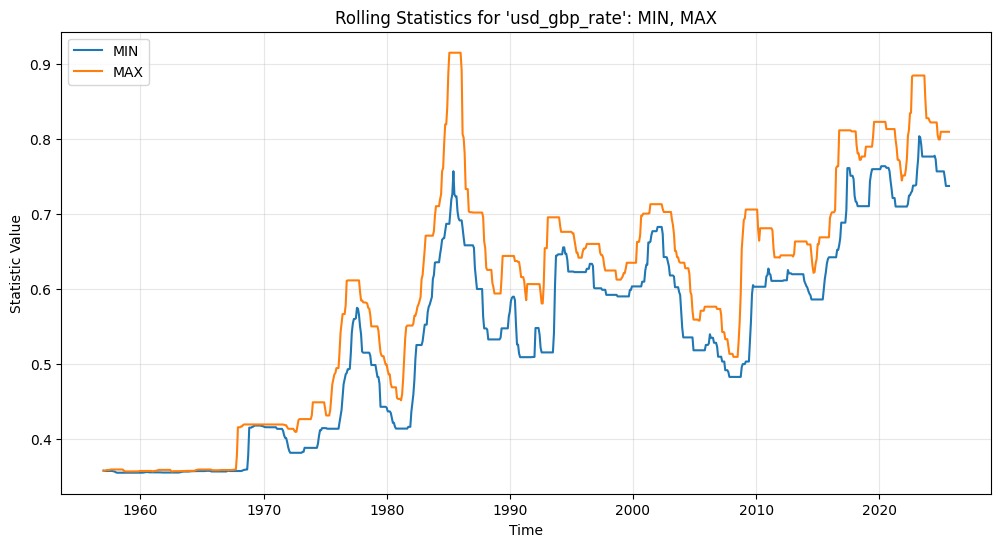

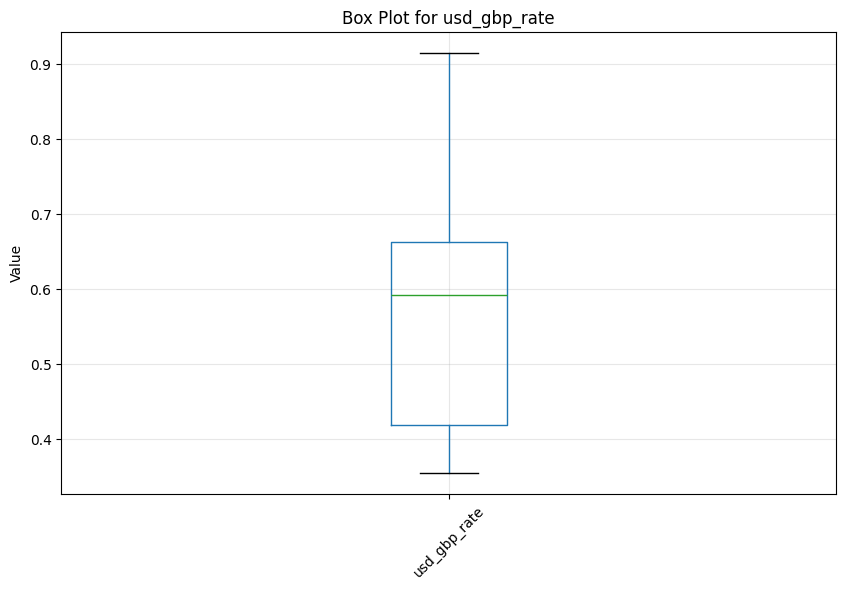

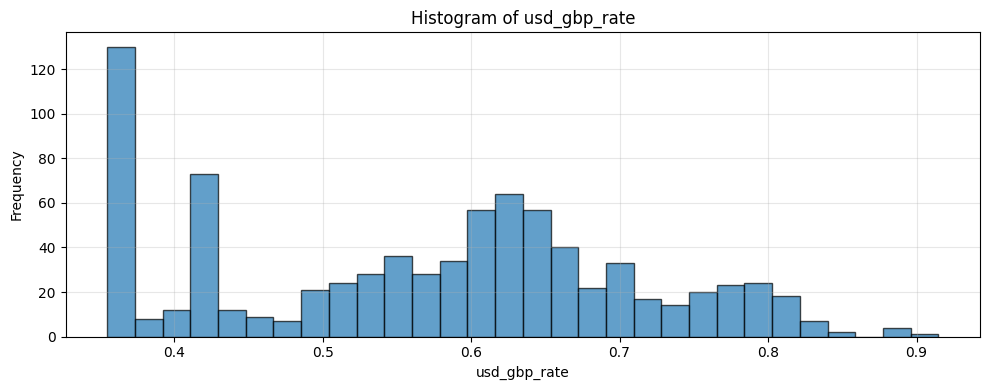

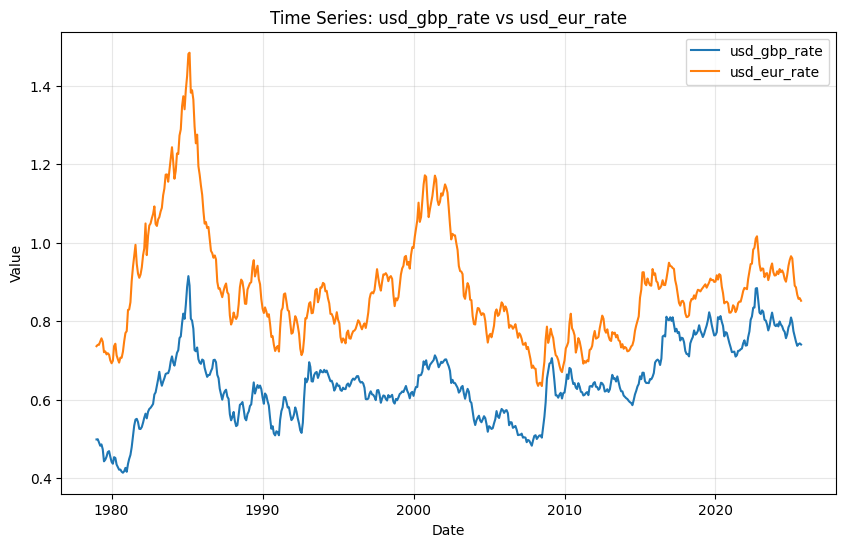

In [ ]:
df = ingest_csv('datasets/usdgbp.csv', 'observation_date')

plot_rolling_stats(df, 'usd_gbp_rate', df.index.min(), df.index.max(), '365D', ['min', 'max'])
plot_boxplot(df, ['usd_gbp_rate'])
plot_histogram(df, ['usd_gbp_rate'])

df1 = ingest_csv('datasets/usdgbp.csv', 'observation_date')
df2 = ingest_csv('datasets/usdeur.csv', 'observation_date')

plot_two_df_line(df1, 'usd_gbp_rate', df2, 'usd_eur_rate')
